## Explore satellite tracks on map
- imports some scripts from ../src/
- plot tracks on map
- plot timeseries

In [1]:
import sys
import os
from datetime import datetime, timedelta
import glob
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import colorcet as cc
import cartopy.crs as ccrs
import numpy as np

project_root = os.path.abspath('/p/i1000617-phd-waveda/dev/satwavepy/src/')
sys.path.append(project_root)
print(project_root)

from satwavepy.vizualize.utils import figure_setup, plot_zebra_border, setup_custom_lat_formatter,create_projection,create_figure_and_axes,add_features, add_model_limits


/p/i1000617-phd-waveda/dev/satwavepy/src


In [2]:
ENV_ROOT = os.getcwd() # environment root directory
OUTPUT_ROOT = '/p/i1000617-phd-waveda/dev/satwavepy/data/raw/satellite'   # output root directory. First download from 01-get_sat_data.ipynb
if OUTPUT_ROOT not in sys.path:
    sys.path.append(OUTPUT_ROOT)
# FIG_ROOT = '../figures/'
os.chdir(ENV_ROOT)

In [3]:
# Define the specific day you're interested in
specific_date = datetime(2022, 1, 27)

# Base directory for output files
OUTPUT_ROOT = '/p/i1000617-phd-waveda/dev/satwavepy/data/raw/satellite/'

# Patterns for different satellite types with their respective subdirectories
patterns = {
    # 'altika': ('al/', '*global_vavh_l3_rt_al_'),
    'jason3': ('jason3/', '*global_vavh_l3_rt_j3_'),
    'sentinel3a': ('sentinel3a/', '*global_vavh_l3_rt_s3a_'),
    'sentinel3b': ('sentinel3b/', '*global_vavh_l3_rt_s3b_'),
    # 'saral': ('sa/', '*global_vavh_l3_rt_sa_'),  
    'cryosat': ('c2/', '*global_vavh_l3_rt_c2_'),
    'cfosat': ('cfo/', '*global_vavh_l3_rt_cfo_'),
    # 'haiyang2b': ('h2b/', '*global_vavh_l3_rt_h2b_'),

}

# Initialize an empty list to hold datasets
datasets = []

# Loop through each satellite type, subdirectory, and pattern
for sat_type, (subdir, pattern_base) in patterns.items():
    # Generate the file pattern for the specific date
    date_str = specific_date.strftime('%Y%m%d')
    pattern = f'{OUTPUT_ROOT}{subdir}{pattern_base}{date_str}*.nc'
    
    # Find all files matching the pattern
    l3_files = glob.glob(pattern)
    l3_files.sort()
    
    # Open each file and add its dataset to the list
    for file in l3_files:
        ds = xr.open_dataset(file, engine='netcdf4')
        ds['satellite_type'] = sat_type  # Add a satellite type identifier
        datasets.append(ds)

        print(ds)

# Concatenate all datasets along the time dimension
combined_dataset = xr.concat(datasets, dim='time')

offset=-4
extent = [-3.0, 10, 51.5, 61.5]  # [min_lon, max_lon, min_lat, max_lat]

# Convert longitudes from 0-360 to -180 to 180 range
longitudes_converted = xr.DataArray([(lon - 360 if lon > 180 else lon) for lon in combined_dataset.longitude.values],
                                    dims=['time'],
                                    coords={'time': combined_dataset.time})

# # Assign the converted longitudes back to the dataset
combined_dataset['longitude'] = longitudes_converted

# Mask the dataset based on the extent
combined_dataset = combined_dataset.where(
    (longitudes_converted >= extent[0]) & (longitudes_converted <= extent[1]) &
    (combined_dataset['latitude'] >= extent[2]) & (combined_dataset['latitude'] <= extent[3]), 
    drop=True)

print(np.unique(combined_dataset.satellite_type.values))

<xarray.Dataset> Size: 242kB
Dimensions:          (time: 5036)
Coordinates:
  * time             (time) datetime64[ns] 40kB 2022-01-27T00:00:00.412256256...
    latitude         (time) float64 40kB ...
    longitude        (time) float64 40kB ...
Data variables:
    VAVH             (time) float64 40kB ...
    VAVH_UNFILTERED  (time) float64 40kB ...
    WIND_SPEED       (time) float64 40kB ...
    satellite_type   <U7 28B 'cryosat'
Attributes: (12/28)
    Conventions:               CF-1.6
    first_meas_time:           2022-01-27 00:00:00.412256
    last_meas_time:            2022-01-27 02:37:46.859113
    comment:                   Significant Wave Height and Wind Speed measure...
    creator_email:             servicedesk.cmems@mercator-ocean.eu
    cdm_data_type:             swath
    ...                        ...
    equator_time:              2022-01-27T00:03:58.990000
    equator_longitude:         302.57
    creation_date:             2022-07-14T02:37:48
    software_version: 

## Plot on map for one day

cfosat
cryosat


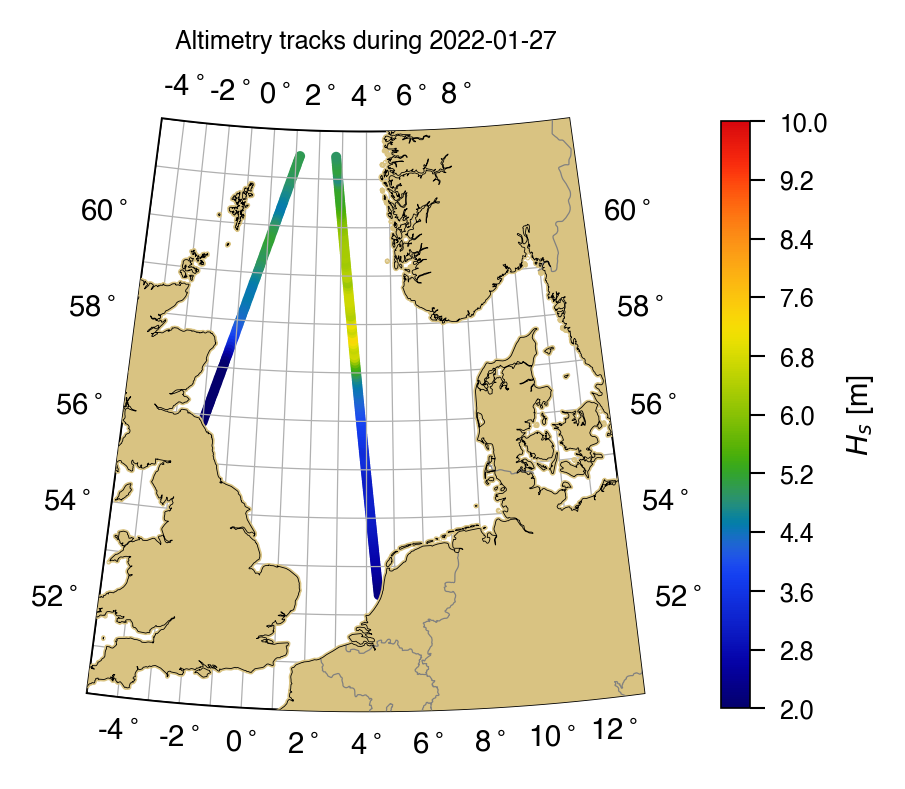

In [7]:
# setup figures
figure_setup()

# Custom orhtographic projection
custom_lat_formatter = setup_custom_lat_formatter()
noProj, myProj = create_projection(model_extent='small') # or model_exten='dcsm' for larger domain
offset = -4
fig = plt.figure(figsize=(3.5433,2.6)) # (3.5433, 2.6)
ax = fig.add_subplot(1, 1, 1, projection=myProj)
ax, gl = add_features(ax)
extent = [-5, 13, 50, 62]  # Set the desired extent
polygon1s = plot_zebra_border(ax, noProj, myProj, extent, model_extent='small')  # or model_exten='dcsm' for larger domain


# Settings
CBAR_SHRINK = 0.9
colormap_hs = cc.cm.rainbow4
extent = [-6.0, 15, 46, 64]  # Set the desired extent
vmin = 2
vmax = 10
offset = -4
index = 15
start_date = datetime(2022, 1, 27) 
end_date = datetime(2022, 1, 28)  

# Define offsets for text annotations
longitude_text_offset = 0.5  # Adjust as needed
latitude_text_offset = 0.5   # Adjust as needed

# Group the dataset by 'satellite_type'
grouped = combined_dataset.groupby('satellite_type')

for sat_type, group in grouped:
    print(sat_type)
    # Plot scatter for the current group
    scatter = ax.scatter(group['longitude'] + offset, group['latitude'], c=group.VAVH, cmap=colormap_hs, vmin=vmin, vmax=vmax, s=2, transform=noProj, zorder=1)
    # Calculate the median longitude and latitude for the group to find the midpoint
    median_longitude = group['longitude'].median().values + offset
    median_latitude = group['latitude'].median().values
    

    # # Apply the text offset when placing the annotation
    # ax.text(median_longitude + longitude_text_offset, median_latitude + latitude_text_offset, sat_type, transform=noProj, fontsize=6, ha='right')

cbar = fig.colorbar(scatter, ax=ax, shrink=CBAR_SHRINK, ticks=np.linspace(vmin, vmax, 11))
cbar.set_label('$H_s$ [m]')
cbar.ax.tick_params(labelsize=6)
cbar.ax.tick_params(width=0.5)



# Little hack needed to plot labels correctly
for ear in gl.ylabel_artists:
    right_label = ear.get_position()[0] > -285984.45115649886
    if right_label:
        ear.set_visible(False)
    else:
        ear.set_visible(True)

for eat in gl.xlabel_artists:
    # print(eat)
    top_label = eat.get_position()[1] > -583774.9898344912
    if top_label:
        eat.set_visible(False)
    else:
        eat.set_visible(True)

ax.set_title("Altimetry tracks during 2022-01-27", fontsize=6)

plt.draw()


fig.tight_layout()

plt.show()

In [11]:

unique_dates = np.unique(np.datetime_as_string(group.time.values, unit='D'))
unique_dates

array(['2022-01-27'], dtype='<U28')

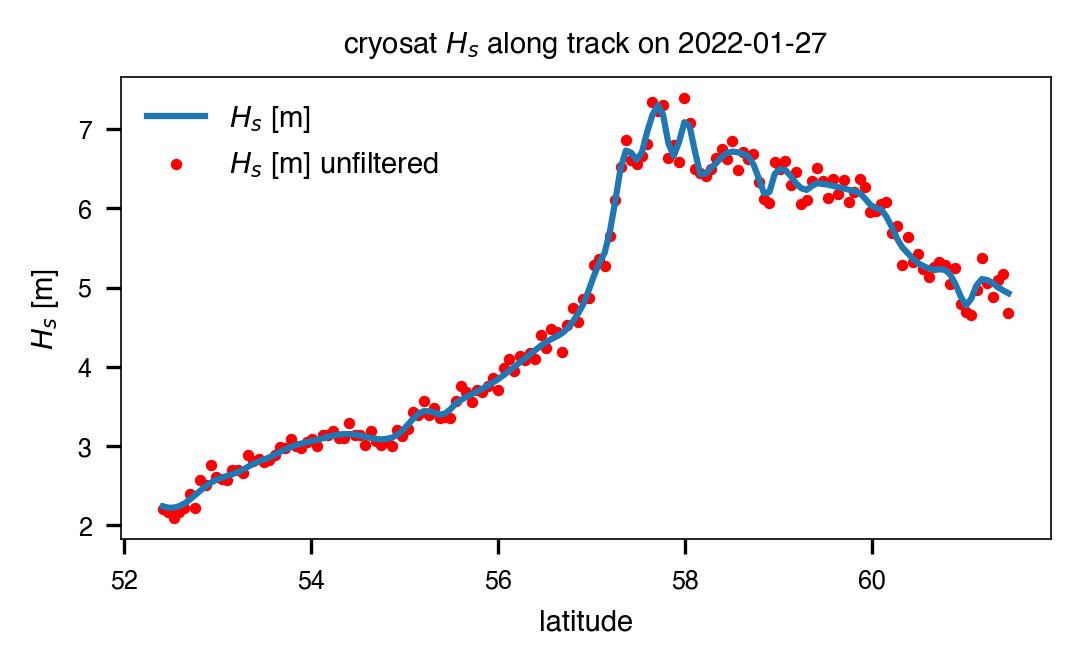

In [23]:

# Plot along track data for each day
for date in unique_dates:
    # Select daily data
    daily_track = group.sel(time=date)
    
    plt.figure(figsize=(4, 2))
    plt.plot(daily_track.latitude, daily_track.VAVH, label='$H_s$ [m]')
    plt.scatter(daily_track.latitude, daily_track.VAVH_UNFILTERED, label='$H_s$ [m] unfiltered', marker='o', color='r', s=3)
    plt.xlabel('latitude')
    plt.ylabel('$H_s$ [m]')
    plt.legend()
    plt.title(f'{np.unique(daily_track.satellite_type)[0]} $H_s$ along track on {date}')